# MultiQC Jupyter Notebook Example

This notebook has some example code showing how MultiQC can be used within an interactive analysis, such as a Jupyter Notebook.

MultiQC is written in Python, so must be used in a Python environment. MultiQC can be installed in a variety of ways: see [the documentation](https://multiqc.info/docs/#installing-multiqc) for more information. Note that MultiQC must be installed into the notebook _kernal_.

First, let's install MultiQC using pip (note the `%` magic which installs the package into the kernel and not the jupyter environment).

In [1]:
%pip install --force-reinstall --upgrade git+https://github.com/MultiQC/MultiQC.git

> NB: You will probably need to restart the notebook kernal after installing MultiQC

Now let's import the `multiqc` package into your workbook:

In [2]:
import multiqc

Great! Now let's check that it's working properly by printing the version that we're using:

In [3]:
print(multiqc.__version__)

1.22.dev0


Before we can use any outputs from MultiQC, we must first run it on some data. Let's grab results from a test run of the [nf-core/viralrecon](https://github.com/nf-core/viralrecon) pipeline.

In [4]:
!wget https://multiqc.info/examples/viralrecon/data.zip
!unzip -o data.zip
!rm data.zip

You should now see a folder called `data/` in your notebook work directory with a bunch of log files from read processing, assembly, alignment, and variant calling. Now let's parse some of those logs.

In [5]:
%ls data

assembly/                         pipeline_info/
fastp/                            summary_assembly_metrics_mqc.csv
fastqc/                           summary_variants_metrics_mqc.csv
kraken2/                          variants/


### Parsing data

Let's parse some `fastp` logs

In [6]:
multiqc.parse_logs('./data/fastp')

/// https://multiqc.info 🔍 v1.22.dev0
       file_search | Search path: /Users/vlad/git/example-notebook/data/fastp
             fastp | Found 3 reports


MultiQC parsed and loaded the `fastp` results into memory. Let's inspect them.

In [7]:
multiqc.list_modules()

['fastp']

In [8]:
multiqc.list_samples()

['SAMPLE1_PE', 'SAMPLE2_PE', 'SAMPLE3_SE']

In [9]:
multiqc.list_data_sources()

['/Users/vlad/git/example-notebook/data/fastp/SAMPLE3_SE.fastp.json',
 '/Users/vlad/git/example-notebook/data/fastp/SAMPLE1_PE.fastp.json',
 '/Users/vlad/git/example-notebook/data/fastp/SAMPLE2_PE.fastp.json']

In [10]:
sample1_result = multiqc.get_module_data(module="fastp", sample="SAMPLE1_PE")
sample1_result["summary"]

{'fastp_version': '0.23.2',
 'sequencing': 'paired end (301 cycles + 301 cycles)',
 'before_filtering': {'total_reads': 55442,
  'total_bases': 16571632,
  'q20_bases': 16267224,
  'q30_bases': 15853021,
  'q20_rate': 0.981631,
  'q30_rate': 0.956636,
  'read1_mean_length': 298,
  'read2_mean_length': 298,
  'gc_content': 0.38526},
 'after_filtering': {'total_reads': 48270,
  'total_bases': 14363465,
  'q20_bases': 14323363,
  'q30_bases': 14199841,
  'q20_rate': 0.997208,
  'q30_rate': 0.988608,
  'read1_mean_length': 298,
  'read2_mean_length': 296,
  'gc_content': 0.383991}}

The MultiQC module for `fastp` implements several plots. The function below lists plot sections, groupped by module name.

In [11]:
multiqc.list_plots()

{'fastp': ['Filtered Reads',
  'Insert Sizes',
  {'Sequence Quality': ['Read 1: Before filtering',
    'Read 1: After filtering',
    'Read 2: Before filtering',
    'Read 2: After filtering']},
  {'GC Content': ['Read 1: Before filtering',
    'Read 1: After filtering',
    'Read 2: Before filtering',
    'Read 2: After filtering']},
  {'N content': ['Read 1: Before filtering',
    'Read 1: After filtering',
    'Read 2: Before filtering',
    'Read 2: After filtering']}]}

You can use this information to call `multiqc.show_plot("<module">, "<section>")` to show plot. When plot has several datasets (like "Sequence Quality", "GC Content", and "N Content" plots), pass the dataset name as well `multiqc.show_plot("<module>", "<section>", "<dataset>")`.

Let's display the GC Content plot.


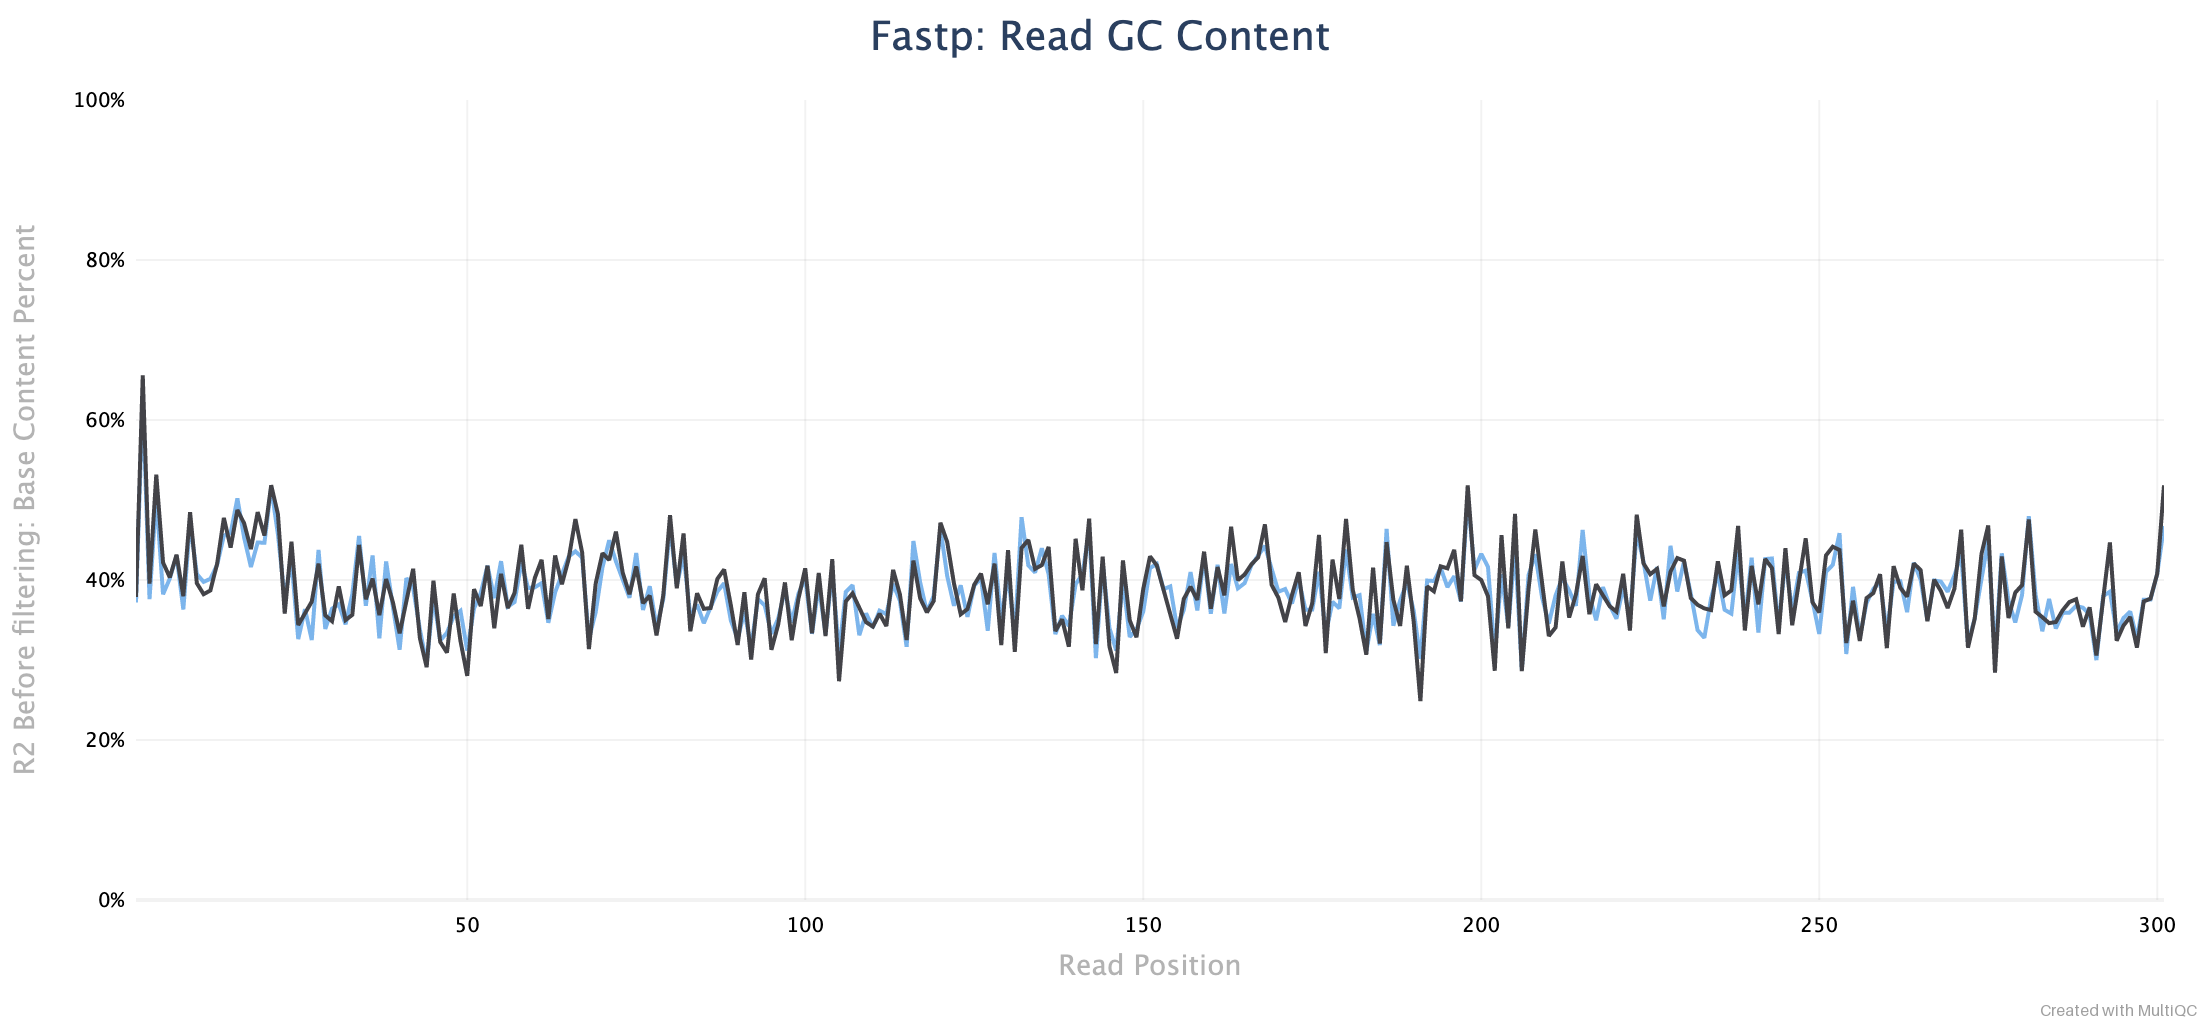

In [12]:
multiqc.show_plot("fastp", "GC Content", dataset="Read 2: Before filtering", flat=True)

The rendered plot is a static image, because the option `flat=True` was provided. To print an interactive plot that you can hover and zoom, omit the `flat` flag.

### Adding more modules

So far we only parsed logs for one module. Now, let's parse more. The original viralrecon workflow uses a [custom script](https://github.com/nf-core/viralrecon/blob/3731dd3a32a67a2648ea22c2bd980c224abdaee2/bin/multiqc_to_custom_csv.py) to summarize data from multiple modules, and we are going to do that interactively, and after that, generate an HTML report.

We also notice that the viralrecon workflow runs QUAST several times: for each assembler separately, and then for the consensus sequence. To keep each run in a separate section, we will use the [module_order](https://multiqc.info/docs/reports/customisation/#running-modules-multiple-times) configuration option to provide path filters for each QUAST run. 

Any custom settings supported by MultiQC can be passed to the function call like that, for example, `extra_fn_clean_exts` can be used to trim additional endings from sample names.

In [13]:
import multiqc
multiqc.parse_logs(
    "./data/assembly",
    "./data/kraken2",
    "./data/variants",
    "./data/fastqc",
    module_order=[
        dict(
            quast=dict(
                name="VARIANTS: QUAST",
                anchor="quast_variants",
                info="This section of the report shows QUAST QC results for the consensus sequence.",
                path_filters=["*/variants/*"],
            )
        ),
        dict(
            quast=dict(
                name="ASSEMBLY: QUAST (SPAdes)",
                anchor="quast_spades",
                info="This section of the report shows QUAST results from SPAdes de novo assembly.",
                path_filters=["*/spades/*"],
            )
        ),
    ],
    extra_fn_clean_exts=[".unclassified", ".pangolin", " MN908947.3", " MN908947.3"]
)
multiqc.list_modules()

/// https://multiqc.info 🔍 v1.22.dev0
       file_search | Search path: /Users/vlad/git/example-notebook/data/assembly
       file_search | Search path: /Users/vlad/git/example-notebook/data/kraken2
       file_search | Search path: /Users/vlad/git/example-notebook/data/variants
       file_search | Search path: /Users/vlad/git/example-notebook/data/fastqc
          bcftools | Found 3 stats reports
           bowtie2 | Found 3 reports
          cutadapt | Found 3 reports
            fastqc | Found 7 reports
            kraken | Found 3 reports
          mosdepth | Found reports for 3 samples
         nextclade | Found 3 samples
          pangolin | Found 3 samples
            picard | Found 2 AlignmentSummaryMetrics reports
            picard | Found 3 BaseDistributionByCycleMetrics reports
            picard | Found 1 InsertSizeMetrics reports
            picard | Found 2 QualityByCycleMetrics reports
            picard | Found 2 QualityScoreDistributionMetrics reports
          samto

['fastp',
 'Bcftools',
 'Bowtie 2 / HiSAT2',
 'Cutadapt',
 'FastQC',
 'Kraken',
 'Mosdepth',
 'Nextclade',
 'Pangolin',
 'Picard',
 'Samtools',
 'SnpEff',
 'VARIANTS: QUAST',
 'ASSEMBLY: QUAST (SPAdes)']

In [14]:
multiqc.list_samples()

['SAMPLE1_PE',
 'SAMPLE1_PE_1',
 'SAMPLE1_PE_2',
 'SAMPLE2_PE',
 'SAMPLE2_PE_1',
 'SAMPLE2_PE_2',
 'SAMPLE2_PE_R1',
 'SAMPLE2_PE_R2',
 'SAMPLE3_SE']

Now there are many more plots available in the session

In [15]:
import pprint
pprint.pprint(multiqc.list_plots())

{'ASSEMBLY: QUAST (SPAdes)': ['Assembly Statistics', 'Number of Contigs'],
 'Bcftools': ['Variant Substitution Types',
              {'Variant Quality': ['Count SNP',
                                   'Count Transitions',
                                   'Count Transversions',
                                   'Count Indels']},
              'Indel Distribution',
              'Variant depths'],
 'Bowtie 2 / HiSAT2': ['Single-end alignments', 'Paired-end alignments'],
 'Cutadapt': ['Filtered Reads',
              {'Trimmed Sequence Lengths': ['Counts', 'Obs/Exp']}],
 'FastQC': ['Sequence Counts',
            'Sequence Quality Histograms',
            'Per Sequence Quality Scores',
            {'Per Sequence GC Content': ['Percentages', 'Counts']},
            'Per Base N Content',
            'Sequence Length Distribution',
            'Sequence Duplication Levels',
            'Overrepresented sequences by sample',
            'Top overrepresented sequences',
            'Status C


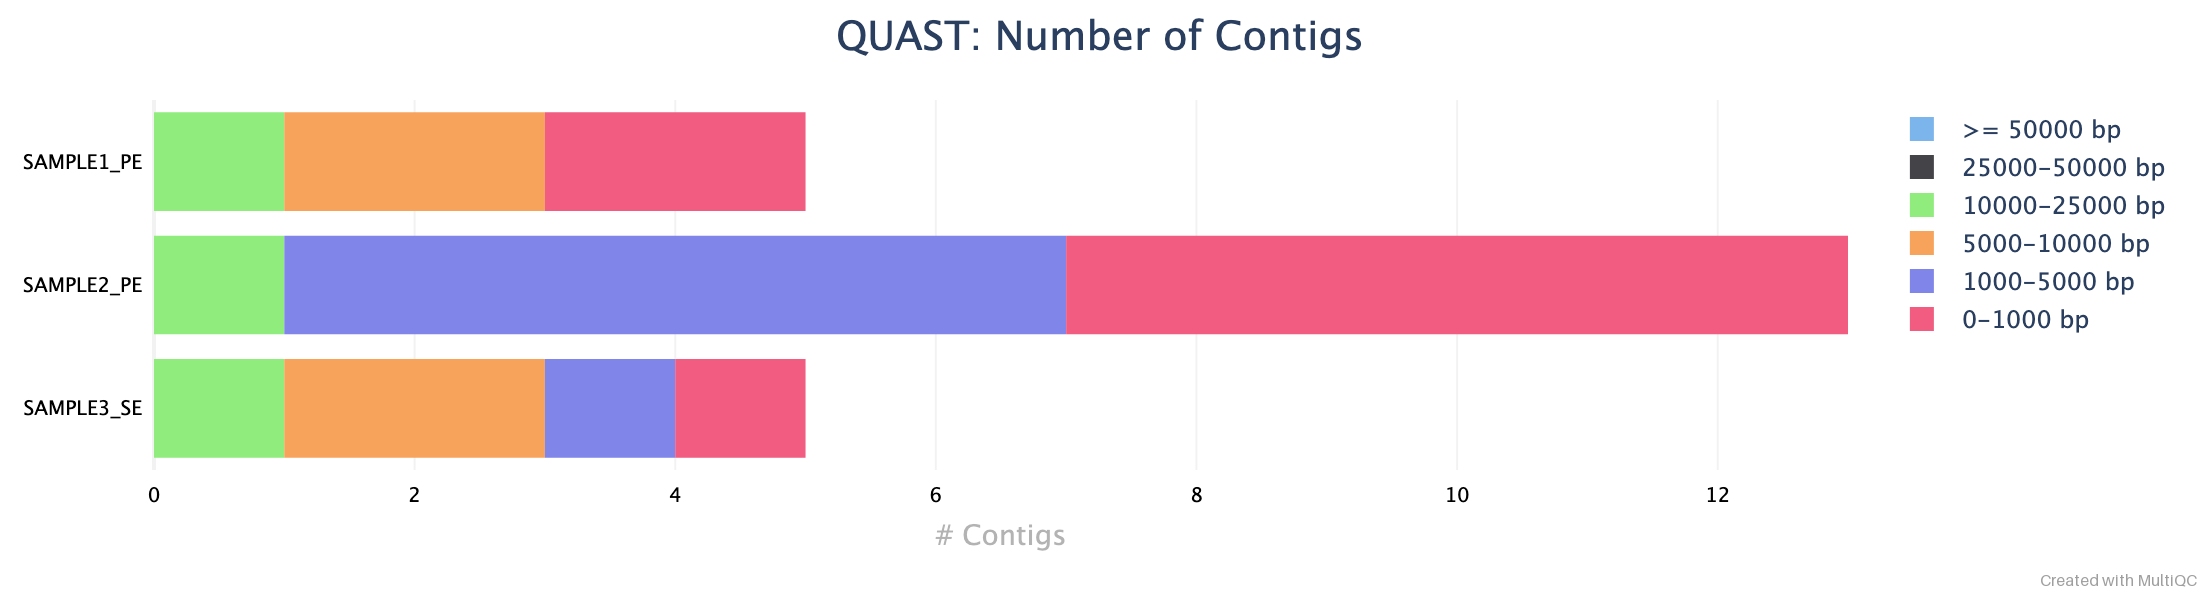

In [16]:
multiqc.show_plot(module="ASSEMBLY: QUAST (SPAdes)", section='Number of Contigs', flat=True)

Now let's re-summarize the data and add a custom section into the report. 

It will be a table, so we will need to define titles for the table columns (`headers`) along with a value for each sample for each column.

We will use the `multiqc.get_module_data()` and `multiqc.get_general_stats_data()` methods to pull data parsed and summarized by modules.

In [22]:
headers = {
    "input_reads": {
        "title": "# Input reads",
        "description": "Total number of reads in raw fastq file",
    },
    "trimmed_read_pairs": {
        "title": "# Trimmed reads (Cutadapt)",
        "description": "Total number of reads remaining after adapter/quality trimming with fastp",
    },
    "num_mapped_reads": {
        "title": "# Mapped reads",
        "description": "Total number of Bowtie2 mapped reads relative to the viral genome",
    },
    "pct_mapped_reads": {
        "title": "% Mapped reads",
        "description": "Percentage of Bowtie2 mapped reads relative to the viral genome",
        "suffix": "%",
    },
    "non_host_reads": {
        "title": "% Non-host reads (Kraken 2)",
        "description": "Total number of non-host reads identified by Kraken2",
    },
    "cov_mean": {
        "title": "Coverage",
        "description": "Mean coverage calculated by mosdepth"
    },
    "number_of_SNPs": {
        "title": "# SNPs",
        "description": "Total number of SNPs",
    },
    "number_of_indels": {
        "title": "# SNPs",
        "description": "Total number of INDELs",
    },
    "missense": {
        "title": "# Missense variants",
        "description": "Total number of variants identified as missense mutations with SnpEff",
    },
    "n_contigs": {
        "title": "# Contigs",
        "description": "Total number of contigs in SPAdes assembly as calculated by QUAST",
    },
    "largest_contig": {
        "title": "Largest contig",
        "description": "Size of largest contig in SPAdes assembly as calculated by QUAST"
    },
    "genome_fraction": {
        "title": "Genome fraction",
        "suffix": "%",
        "description": "% genome fraction for SPAdes assembly as calculated by QUAST",
    },
    "n50": {
        "title": "N50",
        "description": "N50 metric for SPAdes assembly as calculated by QUAST",
    },
    "lineage": {
        "title": "Pangolin lineage",
        "description": "Pangolin lineage inferred from the consensus sequence",
    },
    "clade": {
        "title": "Nextclade clade",
        "description": "Nextclade clade inferred from the consensus sequence",
    },                                  
}

from collections import defaultdict
summarized_data = defaultdict(dict)
for s in multiqc.list_samples():
    if data := multiqc.get_module_data(sample=s, module="fastp"):
        summarized_data[s]["input_reads"] = data["summary"]["before_filtering"]["total_reads"]

    if data := multiqc.get_module_data(sample=s, module="Cutadapt"):
        summarized_data[s]["trimmed_read_pairs"] = data.get("pairs_written")

    if data := multiqc.get_module_data(sample=s, module="Bowtie 2 / HiSAT2"):
        summarized_data[s]["pct_mapped_reads"] = data.get("overall_alignment_rate")

    if data := multiqc.get_module_data(sample=s, module="Samtools", key="multiqc_samtools_stats"):
        summarized_data[s]["num_mapped_reads"] = data.get("reads_mapped")

    if data := multiqc.get_general_stats_data(sample=s):
        summarized_data[s]["non_host_reads"] = data.get("Kraken.pct_unclassified")
        summarized_data[s]["mean_coverage"] = data.get("Mosdepth.mean_coverage")

    if data := multiqc.get_module_data(sample=s, module="Mosdepth"):
        summarized_data[s]["cov_mean"] = data["mean_coverage"]
        
    if data := multiqc.get_module_data(sample=s, module="SnpEff"):
        summarized_data[s]["missense_variants"] = data["MISSENSE"]

    if data := multiqc.get_module_data(sample=s, module="Bcftools"):
        summarized_data[s]["number_of_SNPs"] = data["number_of_SNPs"]
        summarized_data[s]["number_of_indels"] = data["number_of_indels"]

    if data := multiqc.get_module_data(sample=s, module="VARIANTS: QUAST"):
        summarized_data[s]["n_contigs"] = data["# contigs (>= 0 bp)"]
        summarized_data[s]["largest_contig"] = data["Largest contig"]
        summarized_data[s]["genome_fraction"] = data["Genome fraction (%)"]
        summarized_data[s]["n50"] = data["N50"]

    if data := multiqc.get_module_data(sample=s, module="Pangolin"):
        summarized_data[s]["lineage"] = data["lineage"]

    if data := multiqc.get_module_data(sample=s, module="Nextclade"):
        summarized_data[s]["clade"] = data["clade"]

summarized_data = {
    s: {
        k: v for k, v in d.items() if v is not None
    } for s, d in summarized_data.items()
}
summarized_data = {s: d for s, d in summarized_data.items() if d}
import pprint
pprint.pprint(dict(summarized_data))

{'SAMPLE1_PE': {'clade': '20A',
                'genome_fraction': 98.094,
                'input_reads': 55442,
                'largest_contig': 29903.0,
                'lineage': 'B.1',
                'mean_coverage': 433.22,
                'missense_variants': 3.0,
                'n50': 29903.0,
                'n_contigs': 1.0,
                'non_host_reads': 99.95856639734825,
                'num_mapped_reads': 48013.0,
                'number_of_SNPs': 7,
                'number_of_indels': 1,
                'pct_mapped_reads': 99.53,
                'trimmed_read_pairs': 24125},
 'SAMPLE2_PE': {'clade': '19B',
                'genome_fraction': 89.804,
                'input_reads': 42962,
                'largest_contig': 29903.0,
                'lineage': 'A.2',
                'mean_coverage': 343.94,
                'missense_variants': 6.0,
                'n50': 29903.0,
                'n_contigs': 1.0,
                'non_host_reads': 99.78127278408499,
      

Let's show this table:

In [26]:
from multiqc.plots import table
plot = table.plot(
    data=summarized_data,
    headers=headers,
    pconfig={
        "id": "summary_assembly_metrics",
        "title": "Summary Assembly Metrics",
        "description": "Summary of input reads, trimmed reads, and non-host reads.",
    },
)
plot.show()

              plot | Invalid Table plot configuration: {'id': 'summary_assembly_metrics', 'title': 'Summary Assembly Metrics'}:
              plot | - unrecognized field: "description". Available fields: id, table_title, title, height, width, square, logswitch, logswitch_active, logswitch_label, cpswitch, cpswitch_c_active, cpswitch_counts_label, cpswitch_percent_label, xLog, yLog, xlog, ylog, data_labels, xTitle, yTitle, xlab, ylab, xsuffix, ysuffix, tt_suffix, xLabFormat, yLabFormat, yLabelFormat, xlab_format, ylab_format, tt_label, xDecimals, yDecimals, decimalPlaces, x_decimals, y_decimals, tt_decimals, xmin, xmax, ymin, ymax, xFloor, xCeiling, yFloor, yCeiling, x_clipmin, x_clipmax, y_clipmin, y_clipmax, save_data_file, namespace, save_file, raw_data_fn, defaultsort, sort_rows, only_defined_headers, col1_header, no_violin, scale, min


PConfigValidationError: 

We can also display this data as a violin plot, which is a more compact representation for very wide or very tall tables.

In [ ]:
plot.show(violin=True, flat=True)

Let's add this plot into the report. We will prepend th new section to make it appear in the beginning of the report.

In [ ]:
module = multiqc.BaseMultiqcModule(
    name="nf-core/viralrecon summary",
    anchor="custom_data",
)
module.add_section(
    name="De novo assembly metrics",
    anchor="de_novo_assembly_metrics",
    description="Summary of input reads, trimmed reads, and non-host reads. Generated by the nf-core/viralrecon pipeline",
    plot=plot,
)
multiqc.report.modules_output = [module] + multiqc.report.modules_output

We can write the updated report to a file. Since our new section is designed to replace general stats, we will tell MultiQC not to render the general stats table.

In [ ]:
multiqc.write_report(
    force=True,
    title="nf-core/viralrecon report",
    exclude_modules=["general_stats"],   
)
%ls

Now we have a report, we can show it inside the notebook.

In [ ]:
import IPython

# Best if using Google Colab
# IPython.display.HTML(filename='./multiqc_report.html')

# Best if running locally
IPython.display.IFrame('./nf-coreviralrecon-report_multiqc_report.html', '100%', 600)

If you want to restart the session from scratch, you can either restart the kernel, or call `multiqc.reset()`

In [ ]:
multiqc.reset()

Like the command line tool, all interactive commands will load the config in [the same order](https://multiqc.info/docs/getting_started/config/#configuring-multiqc). Any config passed directly to a function (like `module_order` or `exclude_modules` that we specified above) will apply to this function call on top of any config loaded from file. You can also manually load a custom user config with `multiqc.load_config()`:

In [ ]:
multiqc.load_config("multiqc_config_illumina.yml")